# Histopathological Cancer Detection Using Convolutional Neural Networks

### 1. Describe problem

The purpose of this project is to use convolutional neural networks (CNN) to detect cancer based on histology images. The training data contains 220,000 histology images in .tif format, with each image given a unique ID. Ground truth labels for this training data is provided in a csv that labels the images as 0 - no cancer, or 1 - cancer. The test dataset contains 57,000 images. The goal is to train a CNN on the training images, and then use it to predict the cancer status of the test dataset.

Each image is 96 x 96 pixels, and the images are in color, so there are three RGB layers for a final dimension of 96 x 96 x 3.

### 2. Exploratory Data Analysis

First, I will load the required libraries and import the train dataset (just the labels for now).

In [19]:
# Load libraries

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from PIL import Image
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input


In [3]:
# Import train dataset labels

train_df = pd.read_csv("./data/train_labels.csv")
train_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


I will count the number of images in the train and test directories to get the exact size of the dataset here.

In [4]:
# View number of images in train and test datasets

print(len(os.listdir("./data/train")))
print(len(os.listdir("./data/test")))

220025
57458


For the train dataset, I will create a bar graph of the label counts.

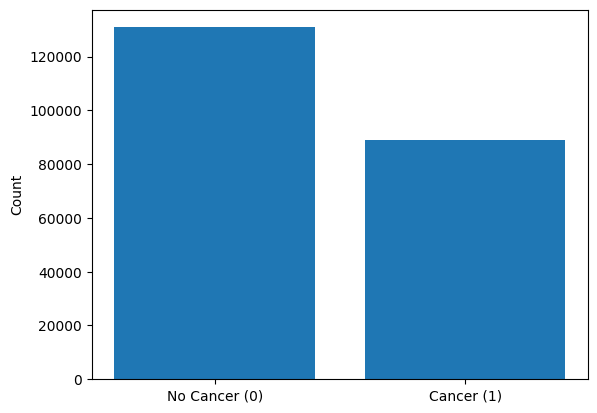

In [5]:
# View distribution of classifications in the train dataset

train_counts = train_df["label"].value_counts()

plt.bar(train_counts.index, train_counts.values)
plt.xticks(train_counts.index, labels=["No Cancer (0)", "Cancer (1)"])
plt.ylabel("Count")
plt.show()

Although there are more 0 (no cancer) labels than 1 (cancer) labels, there are still plenty of examples from each category. Therefore, there shouldn't be any issue with class imbalance. The model should have plenty of examples to learn from.

Next, I will display a few of the images from each category.

In [ ]:
train_image_dir = "./data/train"

cancer_images = train_df[train_df['label'] == 1]['id'].head(3).tolist()
non_cancer_images = train_df[train_df['label'] == 0]['id'].head(3).tolist()

# Helper function to get the first three images from each diagnosis and display them

def display_images(image_ids, title):
    plt.figure(figsize=(8, 5))
    for i, image_id in enumerate(image_ids):
        img_path = os.path.join(train_image_dir, image_id + ".tif")
        img = Image.open(img_path)
        
        plt.subplot(1, 3, i + 1)
        plt.imshow(img)
        plt.title(title)
    plt.show()

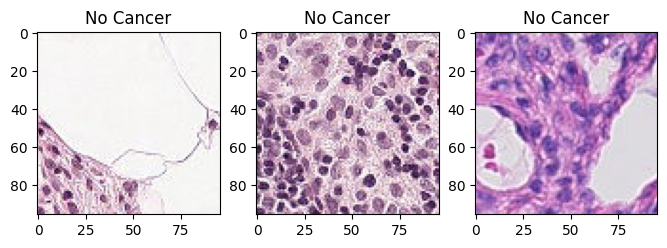

In [7]:
display_images(non_cancer_images, "No Cancer")

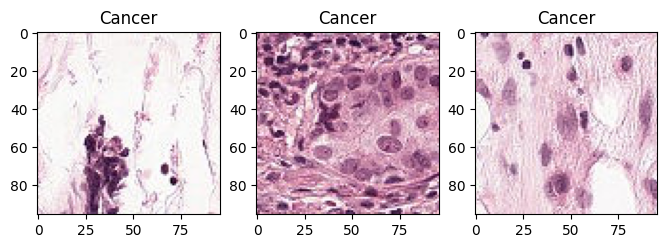

In [8]:
display_images(cancer_images, "Cancer")

I am not a pathologist, so it is not at all obvious to me why the bottom images are from cancer diagnoses while the top ones are healthy. But this is a perfect computer vision task, as we have many images and their accompanying truth labels. A neural network should be able to identify features that differentiate the two groups.

### 3. Model Architecture

My plan is to first try and design a CNN from scratch using the `Sequential()` method from keras. The first step is to load the images for preprocessing and analysis. Due to the sheer size of the training dataset, and the fact that I am limited by the hardware I'm working on (a laptop), I decided to train the model using 10% of the data. This is not ideal, but I think it's necessary due to hardware constraints.

In [ ]:
# Sample a random 10% of the training data 

train_df_subset = train_df.sample(frac=0.1, random_state=234)

train_image_dir = "./data/train"
test_image_dir = "./data/test"

# Helper function to generate the image names and load them

def load_images(image_dir, image_ids, target_size=(96, 96)):
    images = []
    for image_id in image_ids:
        img_path = os.path.join(image_dir, image_id + ".tif")
        img = load_img(img_path, target_size=target_size)
        img = img_to_array(img)
        images.append(img)
    return np.array(images)

In [ ]:
# Load the images and normalize

train_images_subset = load_images(train_image_dir, train_df_subset['id'])
train_labels_subset = train_df_subset['label'].values

train_images_subset /= 255.0

I will now split the data on an 80/20 train to validation split.

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(train_images_subset, train_labels_subset, test_size=0.2, random_state=345)

# X_train /= 255.0
# X_val /= 255.0  

Below is the initial CNN. The input shape is 96 x 96 x 3, reflecting the size of the input images in pixels and the fact that the images are in color, so there are three channels for RGB.

I then put three 2-D convolution layers, the first with 32 filters, then 64 filters, and finally 128 filters, each to capture increasingly complex features in the images. For dimensionality reduction, I included MaxPooling layers.

Then, I flatten the 2-D inputs to a 1-D vector, so that I can put in a dense layer. I included a dropout layer to control for any potential overfitting. And finally, a dense output layer with 1 neuron, using a sigmoid activation function, as this is a binary classification problem.

In [21]:
model = Sequential([
    Input(shape=(96, 96, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),
    
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

I decided to use the `adam` optimizer as it seems to be popular and performs well.

In [22]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])

In [23]:
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)               │ (None, 94, 94, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 47, 47, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 45, 45, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 22, 22, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 20, 20, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 10, 10, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 512)            │     6,554,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 1)              │           513 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,647,873 (25.36 MB)

 Trainable params: 6,647,873 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

Now I will train the model with 20 epochs to start.

In [24]:
history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=20,
    batch_size=32
)

Epoch 1/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 36s 63ms/step - accuracy: 0.5894 - auc: 0.4958 - loss: 0.6806 - val_accuracy: 0.5858 - val_auc: 0.5000 - val_loss: 0.6797
Epoch 2/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 35s 63ms/step - accuracy: 0.5857 - auc: 0.5004 - loss: 0.6794 - val_accuracy: 0.5858 - val_auc: 0.5000 - val_loss: 0.6784
Epoch 3/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 35s 63ms/step - accuracy: 0.5940 - auc: 0.4934 - loss: 0.6760 - val_accuracy: 0.5858 - val_auc: 0.5000 - val_loss: 0.6787
Epoch 4/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 35s 63ms/step - accuracy: 0.5877 - auc: 0.5068 - loss: 0.6778 - val_accuracy: 0.5858 - val_auc: 0.5000 - val_loss: 0.6785
Epoch 5/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 36s 64ms/step - accuracy: 0.5942 - auc: 0.4968 - loss: 0.6757 - val_accuracy: 0.5858 - val_auc: 0.5000 - val_loss: 0.6784
Epoch 6/20
551/551 ━━━━━━━━━━━━━━━━━━━━ 35s 64ms/step - accuracy: 0.5944 - auc: 0.4938 - loss: 0.6758 - val_accuracy: 0.5858 - val_auc: 0.5000 - val_loss: 0.6784
Epoch 7/20
551/551 ━━━━━━━━━

This model is not performing correctly. The training loss is hovering around 0.67, while the validation loss is not improving either.

I will try cutting the final dense layer in half (to 256). I will also normalize the activations at each layer, and add dropout layers at each step.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import tensorflow as tf

model = Sequential([
    Input(shape=(96, 96, 3)),  
    
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),  
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),  
    
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),  
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),  
    
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(), 
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25), 
    
    Flatten(),
    Dense(256, activation='relu'), 
    BatchNormalization(),  
    Dropout(0.5),  
    Dense(1, activation='sigmoid')  
])


model.compile(
    optimizer=Adam(learning_rate=0.001), 
    loss='binary_crossentropy',
    metrics=['accuracy', tf.keras.metrics.AUC()]
)

model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_12 (Conv2D)              │ (None, 96, 96, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 96, 96, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 48, 48, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 48, 48, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_13 (MaxPooling2D) │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 24, 24, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_14 (MaxPooling2D) │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 18432)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │     4,718,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,814,273 (18.36 MB)

 Trainable params: 4,813,313 (18.36 MB)

 Non-trainable params: 960 (3.75 KB)

In training the model, I will also add some early stopping conditions based on validation loss.

In [ ]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
]

history = model.fit(
    X_train, y_train,  
    epochs=50,  
    batch_size=32, 
    validation_data=(X_val, y_val), 
    callbacks=callbacks
)

Epoch 1/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 62s 110ms/step - accuracy: 0.7424 - auc_2: 0.8081 - loss: 0.5819 - val_accuracy: 0.5635 - val_auc_2: 0.5750 - val_loss: 1.0709
Epoch 2/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 61s 110ms/step - accuracy: 0.8094 - auc_2: 0.8776 - loss: 0.4287 - val_accuracy: 0.7923 - val_auc_2: 0.8756 - val_loss: 0.4970
Epoch 3/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 61s 111ms/step - accuracy: 0.8373 - auc_2: 0.9025 - loss: 0.3837 - val_accuracy: 0.6253 - val_auc_2: 0.7112 - val_loss: 1.0100
Epoch 4/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 60s 109ms/step - accuracy: 0.8405 - auc_2: 0.9085 - loss: 0.3700 - val_accuracy: 0.7539 - val_auc_2: 0.8308 - val_loss: 0.6330
Epoch 5/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 60s 110ms/step - accuracy: 0.8460 - auc_2: 0.9178 - loss: 0.3538 - val_accuracy: 0.5810 - val_auc_2: 0.4996 - val_loss: 2.1530
Epoch 6/50
551/551 ━━━━━━━━━━━━━━━━━━━━ 61s 110ms/step - accuracy: 0.8533 - auc_2: 0.9250 - loss: 0.3402 - val_accuracy: 0.6296 - val_auc_2: 0.6701 - val_loss: 0.746

KeyboardInterrupt: 

Here, the model's accuracy was steadily increasing, from 0.74 in epoch 1 to 0.88 in epoch 10. However, the validation accuracy was bouncing all over the place, even dipping below 50% at epoch 7. This is a classic sign of overfitting. For that reason, I decided to stop the training early.

This issue might be mitigated by simply adding more training data. But since I am limited by my hardware, I decided to try a pre-trained CNN model. A popular choice is MobileNet, which is not too computationally intensive [1]. This seems ideal for my situation.

To do this, I loaded the MobileNet model, and added a binary classifier at the end for this problem. I also decided to add image augmentation like rotation and flipping to increase the diversity of the training data, since I already artificially reduced the training size. For clarity, I included the entire workflow in the below cell.

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import AUC
from sklearn.model_selection import train_test_split
import numpy as np
import os
from tensorflow.keras.utils import load_img, img_to_array

# Enable mixed precision

from tensorflow.keras.mixed_precision import set_global_policy
set_global_policy('mixed_float16')

# Load MobileNet model

mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
mobilenet_model.trainable = True 

# Add binary classifier
# Convert feature maps to vector

x = GlobalAveragePooling2D()(mobilenet_model.output)  
x = Dense(128, activation="relu")(x)
x = Dense(1, activation="sigmoid", dtype='float32')(x) 

model_mobilenet = Model(inputs=mobilenet_model.input, outputs=x)

model_mobilenet.compile(
    optimizer=Adam(learning_rate=1e-5), 
    loss="binary_crossentropy", 
    metrics=["accuracy", AUC(name="auc")]
)

# Load images

def load_images(image_dir, image_ids, target_size=(96, 96)):
    images = []
    for image_id in image_ids:
        img_path = os.path.join(image_dir, image_id + ".tif")
        img = load_img(img_path, target_size=target_size)
        img = img_to_array(img)
        images.append(img)
    return np.array(images)

train_images_subset = load_images(train_image_dir, train_df_subset['id'])
train_labels_subset = train_df_subset['label'].values

# Normalize 

train_images_subset /= 255.0

# Split

X_train, X_val, y_train, y_val = train_test_split(train_images_subset, train_labels_subset, test_size=0.2, random_state=345)

# Define augmentation function

def augment_image(image, label):
    # Random horizontal flip
    image = tf.image.random_flip_left_right(image)
    # Random rotation (90 degrees)
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    return image, label

def create_dataset(images, labels, batch_size=16, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if augment:
        dataset = dataset.map(
            augment_image, 
            num_parallel_calls=tf.data.AUTOTUNE
        )
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Create training and validation datasets with the augmentation

train_dataset = create_dataset(X_train, y_train, batch_size=16, augment=True)
val_dataset = create_dataset(X_val, y_val, batch_size=16)

# Early stopping condition

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

In [ ]:
# Train the model

history = model_mobilenet.fit(
    train_dataset,
    epochs=5, 
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/5
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 177s 161ms/step - accuracy: 0.8558 - auc: 0.9276 - loss: 0.3344 - val_accuracy: 0.8618 - val_auc: 0.9438 - val_loss: 0.3183
Epoch 2/5
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 178s 161ms/step - accuracy: 0.8652 - auc: 0.9387 - loss: 0.3071 - val_accuracy: 0.8893 - val_auc: 0.9501 - val_loss: 0.2762
Epoch 3/5
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 175s 159ms/step - accuracy: 0.8782 - auc: 0.9470 - loss: 0.2865 - val_accuracy: 0.8928 - val_auc: 0.9523 - val_loss: 0.2700
Epoch 4/5
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 179s 163ms/step - accuracy: 0.8863 - auc: 0.9524 - loss: 0.2720 - val_accuracy: 0.8966 - val_auc: 0.9557 - val_loss: 0.2604
Epoch 5/5
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 180s 163ms/step - accuracy: 0.8918 - auc: 0.9590 - loss: 0.2531 - val_accuracy: 0.9005 - val_auc: 0.9588 - val_loss: 0.2496


Due to the long training time, I decided to only run 5 epochs. The output from this model is much better than the previous CNN models which were trained from scratch. The training accuracy consistently increases from 0.8558 in epoch 1 to 0.8918 in epoch 5. The validation accuracy also steadily increases from 0.86 to 0.90, which shows that this model, unlike previous models, is not overfitting.

Below, I graphed the training and validation accuracies and losses accross the five epochs.

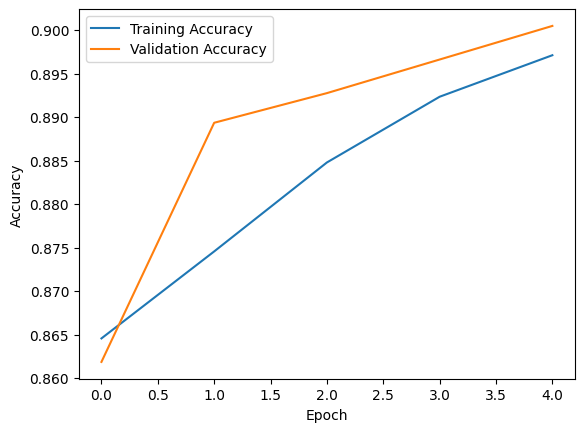

In [ ]:
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

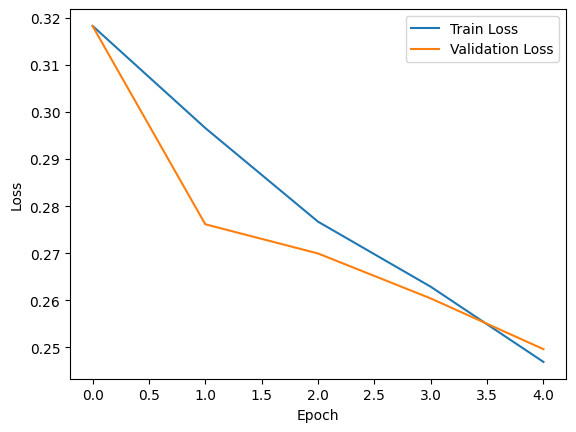

In [57]:
plt.plot(history.history['loss'], label="Train Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### 4. Results, Analysis, and Hyperparameter Tuning

Due to the fact that I am hardware limited, I was not able to perform proper hyperparameter tuning using a grid search. Instead, I decided to change just one hyperparamter: the learning rate. Since I am only running 5 epochs, I decided to increase the learning rate by one order of magnitude, from 1e-5 to 1e-4. Faster learning rate should help the training to converge faster.

I copied the entire model and data generation below for simplicity.

In [ ]:
set_global_policy('mixed_float16')

# Load MobileNet model

mobilenet_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(96, 96, 3))
mobilenet_model.trainable = True 

# Add binary classifier
# Convert feature maps to vector

x = GlobalAveragePooling2D()(mobilenet_model.output)  
x = Dense(128, activation="relu")(x)
x = Dense(1, activation="sigmoid", dtype='float32')(x) 

model_mobilenet = Model(inputs=mobilenet_model.input, outputs=x)

model_mobilenet.compile(
    optimizer=Adam(learning_rate=1e-4), 
    loss="binary_crossentropy", 
    metrics=["accuracy", AUC(name="auc")]
)

# Load images

def load_images(image_dir, image_ids, target_size=(96, 96)):
    images = []
    for image_id in image_ids:
        img_path = os.path.join(image_dir, image_id + ".tif")
        img = load_img(img_path, target_size=target_size)
        img = img_to_array(img)
        images.append(img)
    return np.array(images)

train_images_subset = load_images(train_image_dir, train_df_subset['id'])
train_labels_subset = train_df_subset['label'].values

# Normalize 

train_images_subset /= 255.0

# Split

X_train, X_val, y_train, y_val = train_test_split(train_images_subset, train_labels_subset, test_size=0.2, random_state=345)

# Define augmentation function

def augment_image(image, label):
    # Random horizontal flip
    image = tf.image.random_flip_left_right(image)
    # Random rotation (90 degrees)
    image = tf.image.rot90(image, k=tf.random.uniform(shape=[], minval=0, maxval=4, dtype=tf.int32))
    return image, label

def create_dataset(images, labels, batch_size=16, augment=False):
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    if augment:
        dataset = dataset.map(
            augment_image, 
            num_parallel_calls=tf.data.AUTOTUNE
        )
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

# Create training and validation datasets with the augmentation

train_dataset = create_dataset(X_train, y_train, batch_size=16, augment=True)
val_dataset = create_dataset(X_val, y_val, batch_size=16)

# Early stopping condition

callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
]

In [ ]:
# Train the model

history2 = model_mobilenet.fit(
    train_dataset,
    epochs=5,
    validation_data=val_dataset,
    callbacks=callbacks
)

Epoch 1/5
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 169s 144ms/step - accuracy: 0.8025 - auc: 0.8761 - loss: 0.4245 - val_accuracy: 0.8457 - val_auc: 0.9220 - val_loss: 0.4264
Epoch 2/5
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 162s 147ms/step - accuracy: 0.8842 - auc: 0.9472 - loss: 0.2855 - val_accuracy: 0.8616 - val_auc: 0.9403 - val_loss: 0.3406
Epoch 3/5
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 163s 148ms/step - accuracy: 0.8980 - auc: 0.9619 - loss: 0.2423 - val_accuracy: 0.8941 - val_auc: 0.9591 - val_loss: 0.2672
Epoch 4/5
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 163s 148ms/step - accuracy: 0.9137 - auc: 0.9689 - loss: 0.2165 - val_accuracy: 0.8996 - val_auc: 0.9598 - val_loss: 0.2695
Epoch 5/5
1101/1101 ━━━━━━━━━━━━━━━━━━━━ 162s 147ms/step - accuracy: 0.9264 - auc: 0.9764 - loss: 0.1895 - val_accuracy: 0.8964 - val_auc: 0.9598 - val_loss: 0.3019


Indeed, increasing the learning rate did help the training to converge faster. Here, the training accuracy increased 12% over the five epochs, whereas it previously increased by 4%. The validation accuracy was not improved, however, which suggests that this model is not necessarily an improvement over the previous one.

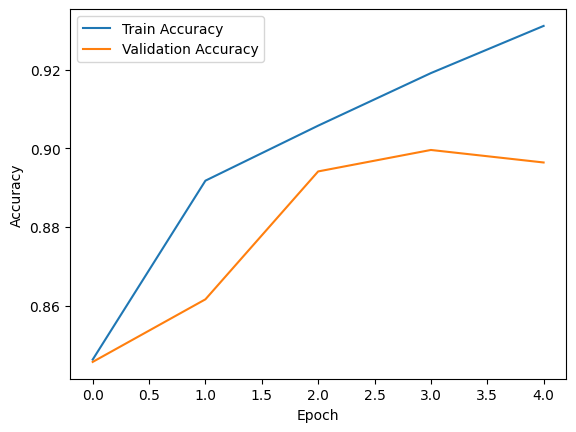

In [51]:
plt.plot(history2.history['accuracy'], label='Train Accuracy')
plt.plot(history2.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

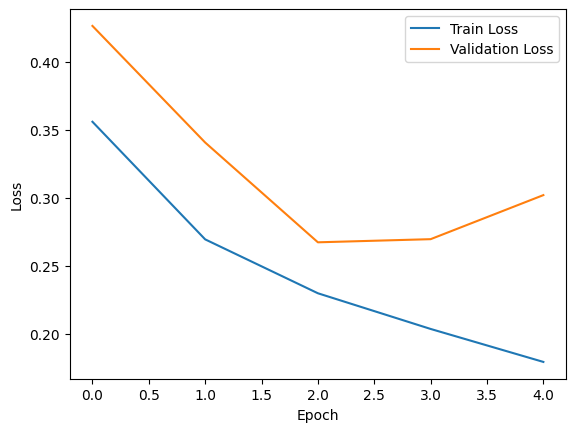

In [58]:
plt.plot(history2.history['loss'], label="Train Loss")
plt.plot(history2.history['val_loss'], label="Validation Loss")
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

While the training loss decreases consistently over the five epochs, the validation loss starts to increase after epoch 3. This shows that the learning rate is too high, and that the previous learning rate of 1e-5 is better.

Below is a summary of the changes that resulted from increasing the learning rate.

| Learning Rate | Final Train Accuracy | Final Validation Accuracy |
| - | - | - |
| 1e-5 | 0.8918 | 0.9005 |
| 1e-4 | 0.9264 | 0.8964 |

### 5. Conclusion

To evaluate this final model, I will use it to predict the diagnoses for the test images. 

In [ ]:
# Load test images

test_ids = [os.path.splitext(img)[0] for img in os.listdir(test_image_dir)]
test_images = load_images(test_image_dir, test_ids)

# Normalize

test_images /= 255.0

# Make predictions

predictions = model_mobilenet.predict(test_images)

1796/1796 ━━━━━━━━━━━━━━━━━━━━ 105s 58ms/step


In [ ]:
# Convert from probability to binary, export as csv for submission to kaggle

binary_predictions = (predictions >= 0.5).astype(int)

submission_df = pd.DataFrame({
    'id': test_ids,
    'label': binary_predictions.flatten()  # Use binary labels
})

submission_df.to_csv('mobilenet2.csv', index=False)

<img src="./submission.png">

The model performs reasonably well on the test data at 0.8345 accuracy. This is a little bit worse than how the model performed on the validation data, but it is still a reasonably good performance considering the fact that I only trained the data on 10% of the possible training images.

Overall, my initial attempt at creating a CNN from scratch was unsuccessful--it quickly overfit the data, and could not reliably increase the validation accuracy. This could be due to a variety of issues, but I think the most obvious one is that I could only train it on 10% of the training data. This prompted me to utilize a pre-trained CNN model, MobileNet, which is commonly used in portable applications due to its being very efficient and not computationally expensive. This approach worked much better, as I was able to achieve a reasonably good roughly 90% validation accuracy using the model. I also experimented with the learning rate, increasing it from 1e-5 to 1e-4. I found that the smaller learning rate was a bit better, as the larger learning rate led to the model overfitting and the validation loss increasing at the later epochs.

In the future, I would like to train this model on the full dataset as opposed to just a tenth of it to see how much the performance improves. If I had better hardware to work with, I would also like to revisit creating the CNN from scratch, as opposed to using the pre-trained MobileNet model. This project illustrates that computer vision tasks really need lots of training data to effectively find features.

### References

1. https://medium.com/@godeep48/an-overview-on-mobilenet-an-efficient-mobile-vision-cnn-f301141db94d